In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from crnn import CNN_BiGRU_Classifier
import math
from tqdm.notebook import tqdm
import numpy as np
from training_data import data_preproc, load_pre_data
from sklearn.model_selection import train_test_split
from greedy_decoder import GreedyCTCDecoder, beam_search_decoder
from utils import get_actual_transcript, get_model_savepath, get_motifs_identified
import torchaudio
import datetime

# Tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

X,y = data_preproc(chop_reads=1)
print(f"Number of samples: {len(X)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)
print(f"Running on {device}")

labels_int = np.arange(14).tolist()
labels = [f"{i}" for i in labels_int] # Tokens to be fed into greedy decoder
greedy_decoder = GreedyCTCDecoder(labels=labels)

model_save_path = get_model_savepath()
model_save_iterations = 200

# Model Parameters
input_size = 1  # Number of input channels
hidden_size = 128
num_layers = 4
output_size = 14  # Number of output classes
dropout_rate = 0.2

saved_model = True

# Model Definition
model = CNN_BiGRU_Classifier(input_size, hidden_size, num_layers, output_size, dropout_rate)

if saved_model:
    model_path = "models/model.pth"

    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
ctc_loss = nn.CTCLoss(zero_infinity=True)

presaved = False

"""
if presaved:
    X, y = load_pre_data()
else:
    X,y = data_preproc()
"""
    
# Creating Train, Test, Validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

torch.autograd.set_detect_anomaly(True)

n_classes = 14
step_sequence = 100
window_overlap = 50
length_per_sample = 150
model_output_split_size = 1

epochs = 2

"""
# Add over epochs
for epoch in range(epochs):

    #################### Training Loop #################
    print(f"Epoch {epoch}")
    model.train()
    for i in tqdm(range(len(X_train))):

        training_sequence, target_sequence = X_train[i].to(device), torch.tensor(y_train[i]).to(device)

        input_lengths = torch.tensor(X_train[i].shape[0])
        target_lengths = torch.tensor(len(target_sequence))

        # Zero out the gradients
        optimizer.zero_grad()
        

        try:        
            
            # Give the model the input in chunks based on the model_output_split_size flag
            if model_output_split_size > 1:
                model_output_timestep = torch.zeros([input_lengths, output_size]).to(device)
                stepper_size = (input_lengths + model_output_split_size - 1) // model_output_split_size  # Adjust stepper_size to cover all elements

                for j in range(0, input_lengths, stepper_size):
                    end_index = min(j + stepper_size, len(target_sequence))
                    
                    # Get the model output for the current chunk
                    model_output_chunk = model(training_sequence[j:end_index])
                    
                    # Ensure the sizes match before assignment
                    model_output_timestep[j:end_index] = model_output_chunk
                        
            else:
                model_output_timestep = model(training_sequence) # Getting model output

            loss = ctc_loss(model_output_timestep, target_sequence, input_lengths, target_lengths)
            
            loss.backward()
            # Update the weights
            optimizer.step()

        except Exception as e:
            print(f"Error at {i}")
            print(e)
            model_output_split_size += 1
            continue

        
        if i % 100 == 0:
            print(f"\nEpoch {epoch} Batch {i}")
            print(f"Loss {loss.item()}")
            greedy_result = greedy_decoder(model_output_timestep)
            greedy_transcript = " ".join(greedy_result)
            actual_transcript = get_actual_transcript(target_sequence)
            motif_err = torchaudio.functional.edit_distance(actual_transcript, greedy_result) / len(actual_transcript)

            motifs_identifed = get_motifs_identified(actual_transcript, greedy_transcript)

            print(f"Transcript: {greedy_transcript}")
            print(f"Actual Transcript: {actual_transcript}")
            print(f"Motif Error Rate: {motif_err}")
            print(f"Motifs Identified: {motifs_identifed}")

            writer.add_scalar("Loss/train", loss, epoch)
            writer.add_scalar("Err/Train", motif_err, epoch)
        
        # Saving model weights
        if i % model_save_iterations == 0:
            torch.save({
            'epoch': epoch,
            'batch':i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, model_save_path)

    ################## Validation Loop ####################
    
    model.eval()
    val_loss = 0.0
    distances_arr = []
    motifs_identifed_arr = []
    with torch.no_grad():
        for i in tqdm(range(len(X_val))):

            validation_sequence, target_sequence = torch.tensor(X_val[i]).to(device), torch.tensor(y_val[i]).to(device)

            model_output_timestep = model(validation_sequence) # Getting model output

            input_lengths = torch.tensor(X_val[i].shape[0])
            target_lengths = torch.tensor(len(target_sequence))

            loss = ctc_loss(model_output_timestep, target_sequence, input_lengths, target_lengths)

            greedy_result = greedy_decoder(model_output_timestep)
            greedy_transcript = " ".join(greedy_result)
            actual_transcript = get_actual_transcript(target_sequence)
            
            motif_err = torchaudio.functional.edit_distance(actual_transcript, greedy_result) / len(actual_transcript)
            distances_arr.append(motif_err)

            motifs_identifed = get_motifs_identified(actual_transcript, greedy_transcript)
            motifs_identifed_arr.append(motifs_identifed)

            val_loss += loss.item()

    val_loss /= len(X_val)
    val_accuracy = np.mean(distances_arr)
    motifs_identifed = np.mean(motifs_identifed_arr)
    print(f"Epoch {epoch}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Motifs Identified: {motifs_identifed:.4f}")
    writer.add_scalar("Loss/validation", val_loss, epoch)

"""
    

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:26<00:00, 742.54it/s]


Number of samples: 20000
Running on cuda


'\n# Add over epochs\nfor epoch in range(epochs):\n\n    #################### Training Loop #################\n    print(f"Epoch {epoch}")\n    model.train()\n    for i in tqdm(range(len(X_train))):\n\n        training_sequence, target_sequence = X_train[i].to(device), torch.tensor(y_train[i]).to(device)\n\n        input_lengths = torch.tensor(X_train[i].shape[0])\n        target_lengths = torch.tensor(len(target_sequence))\n\n        # Zero out the gradients\n        optimizer.zero_grad()\n        \n\n        try:        \n            \n            # Give the model the input in chunks based on the model_output_split_size flag\n            if model_output_split_size > 1:\n                model_output_timestep = torch.zeros([input_lengths, output_size]).to(device)\n                stepper_size = (input_lengths + model_output_split_size - 1) // model_output_split_size  # Adjust stepper_size to cover all elements\n\n                for j in range(0, input_lengths, stepper_size):\n        

In [1]:



# Test Loop
model.eval()
test_loss = 0.0
distances_arr = []
motifs_identifed_arr = []
greedy_transcripts = []
actual_transcripts = []
with torch.no_grad():
    for i in tqdm(range(len(X_test))):

        test_sequence, target_sequence = torch.tensor(X_test[i]).to(device), torch.tensor(y_test[i]).to(device)

        model_output_timestep = model(test_sequence) # Getting model output

        input_lengths = torch.tensor(X_test[i].shape[0])
        target_lengths = torch.tensor(len(target_sequence))

        loss = ctc_loss(model_output_timestep, target_sequence, input_lengths, target_lengths)
        test_loss += loss.item()

        greedy_result = greedy_decoder(model_output_timestep)
        greedy_transcript = " ".join(greedy_result)
        actual_transcript = get_actual_transcript(target_sequence)
        greedy_transcripts.append(greedy_transcript)
        actual_transcripts.append(actual_transcript)


        motif_err = torchaudio.functional.edit_distance(actual_transcript, greedy_transcript) / len(actual_transcript)
        distances_arr.append(motif_err)

        motifs_identifed = get_motifs_identified(actual_transcript, greedy_transcript)
        motifs_identifed_arr.append(motifs_identifed)


test_loss /= len(X_test)
test_accuracy = np.mean(distances_arr)
motifs_identifed = np.mean(motifs_identifed_arr)
print(f"Test Loss: {test_loss:.4f}, Test Edit Distance: {test_accuracy:.4f}, Motifs Identified: {motifs_identifed:.4f}")


NameError: name 'model' is not defined

In [3]:
import matplotlib.pyplot as plt

## Percentage of motifs identified

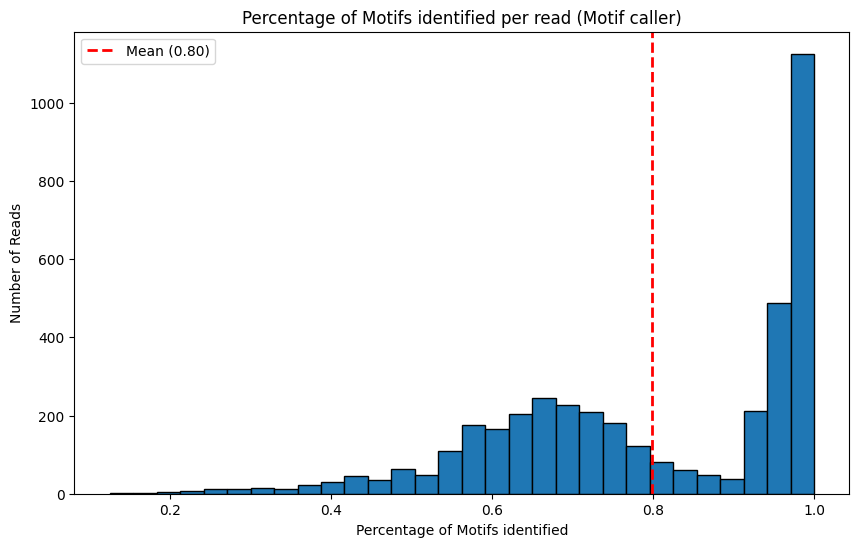

In [4]:
accuracies = motifs_identifed_arr
# Calculate mean and median
mean_accuracy = np.mean(accuracies)

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(accuracies, bins=30, edgecolor='black')

# Add mean and median lines
plt.axvline(mean_accuracy, color='red', linestyle='dashed', linewidth=2, label=f'Mean ({mean_accuracy:.2f})')

# Customize the plot
plt.title('Percentage of Motifs identified per read (Motif caller)')
plt.xlabel('Percentage of Motifs identified')
plt.ylabel('Number of Reads')
plt.legend()

# Show the plot
plt.show()

## Read Distance Distribution

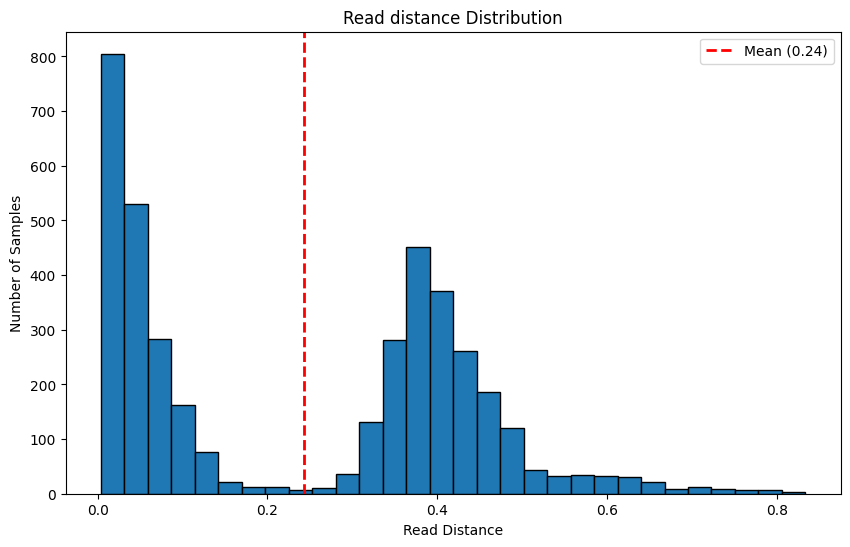

In [5]:

accuracies = distances_arr
# Calculate mean and median
mean_accuracy = np.mean(accuracies)

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(accuracies, bins=30, edgecolor='black')

# Add mean and median lines
plt.axvline(mean_accuracy, color='red', linestyle='dashed', linewidth=2, label=f'Mean ({mean_accuracy:.2f})')

# Customize the plot
plt.title('Read distance Distribution')
plt.xlabel('Read Distance')
plt.ylabel('Number of Samples')
plt.legend()

# Show the plot
plt.show()

## Error by Motif Choice

In [6]:
def get_motif_counts(read_motifs):
    motif_counts = np.zeros(13, dtype=int)
    for motif in read_motifs:
        motif_counts[motif-1] += 1
    return motif_counts

motifs_missed = np.zeros(13, dtype=int)
total_motifs = np.zeros(13, dtype=int)

for i, j in zip(greedy_transcripts, actual_transcripts):

    i = eval('['+i.replace(' ',',') +']')

    j = j.strip()
    j = eval('['+j.replace(' ',',') +']')

    motif_counts_per_read = get_motif_counts(i)
    dataset_motif_counts = get_motif_counts(j)

    motifs_missed = [
            i + (k - j) if k>j else i for i, j, k in zip(
                motifs_missed, motif_counts_per_read, 
                dataset_motif_counts
            )
        ]
    total_motifs = [i + j for i, j in zip(total_motifs, dataset_motif_counts)]


In [20]:
percentage_motifs_missed = [i/j for i,j in zip(motifs_missed, total_motifs)]

In [21]:
percentage_motifs_missed

[0.10629744035515266,
 0.2490049751243781,
 0.17147117296222664,
 0.24420788979336255,
 0.23159700561447286,
 0.3884959924563885,
 0.1804418353159277,
 0.36564756491012446,
 0.30166196299780496,
 0.30865172087148723,
 0.23724095267553355,
 0.3018955873213176,
 0.33064883756268043]

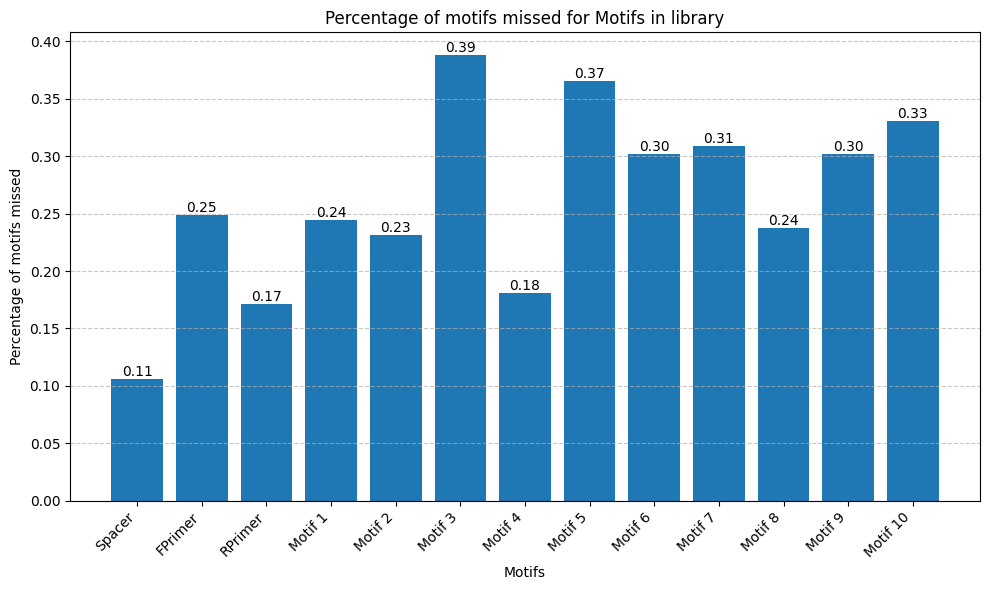

In [22]:
motif_labels = ["Spacer", "FPrimer", "RPrimer"] + [f"Motif {i+1}" for i in range(10)]
missed_counts = motifs_missed
motifs = motif_labels

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(motifs, percentage_motifs_missed)

# Customize the chart
plt.title('Percentage of motifs missed for Motifs in library')
plt.xlabel('Motifs')
plt.ylabel('Percentage of motifs missed')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels if they overlap
plt.xticks(rotation=45, ha='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Alignment Metric

In [74]:
# So for each read - get the information motifs from the target  
# Similary for the prediction
# See what difference is there -> direct correct prediction or next matches or whatever

counter = 0
for i, j in zip(greedy_transcripts, actual_transcripts):

    i = eval('['+i.replace(' ',',') +']')

    j = j.strip()
    j = eval('['+j.replace(' ',',') +']')

    print([t for t in i if not (t == 1 or t==2 or t==3)])
    print([t for t in j if not (t == 1 or t==2 or t==3)])
    print()

    if counter == 5:
        break
    counter +=1


[4, 9, 4, 11, 11, 9, 12, 9, 5, 13]
[6, 9, 8, 5, 11, 5, 13, 6, 13, 7, 5]

[4, 11, 9, 13, 6, 4, 5, 10, 9, 11, 5, 11, 12, 8, 13, 11, 5, 13, 13]
[4, 11, 9, 13, 6, 4, 5, 10, 9, 11, 5, 11, 12, 8, 13, 11, 5, 13, 13, 8]

[11, 8, 5, 12, 7, 5, 13, 11, 4, 5, 7, 9, 9, 13, 13, 9]
[11, 8, 5, 12, 11, 13, 7, 5, 13, 11, 4, 5, 7, 9, 9, 13, 13, 9]

[7, 5, 7, 4, 13, 12]
[5, 7, 4, 13, 12]

[13, 9, 10, 13, 10, 7, 12, 7, 7, 4]
[6, 13, 5, 5, 11, 13, 13, 8, 11, 8, 6, 10, 11, 13, 4]

[5, 7, 7, 9, 13, 5, 7, 13, 4, 7]
[5, 7, 4, 13, 6, 12, 13, 5, 7, 10, 13, 7]



In [75]:
def alignment_errors(seq1, seq2):
    m, n = len(seq1), len(seq2)
    dp = [[[0, ''] for _ in range(n + 1)] for _ in range(m + 1)]
    
    for i in range(m + 1):
        dp[i][0] = [i, 'D' * i]
    for j in range(n + 1):
        dp[0][j] = [j, 'I' * j]
    
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if seq1[i-1] == seq2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                deletion = dp[i-1][j][0] + 1
                insertion = dp[i][j-1][0] + 1
                substitution = dp[i-1][j-1][0] + 1
                
                min_op = min(deletion, insertion, substitution)
                dp[i][j][0] = min_op
                
                if min_op == deletion:
                    dp[i][j][1] = dp[i-1][j][1] + 'D'
                elif min_op == insertion:
                    dp[i][j][1] = dp[i][j-1][1] + 'I'
                else:
                    dp[i][j][1] = dp[i-1][j-1][1] + 'S'
    
    operations = dp[m][n][1]
    max_length = max(m, n)
    
    insertions = operations.count('I') / max_length
    deletions = operations.count('D') / max_length
    substitutions = operations.count('S') / max_length
    
    return insertions, deletions, substitutions

# Example sequences
sequence_pairs = [
    ([4, 9, 4, 11, 11, 9, 12, 9, 5, 13], [6, 9, 8, 5, 11, 5, 13, 6, 13, 7, 5]),
    ([4, 11, 9, 13, 6, 4, 5, 10, 9, 11, 5, 11, 12, 8, 13, 11, 5, 13, 13], 
     [4, 11, 9, 13, 6, 4, 5, 10, 9, 11, 5, 11, 12, 8, 13, 11, 5, 13, 13, 8]),
    ([11, 8, 5, 12, 7, 5, 13, 11, 4, 5, 7, 9, 9, 13, 13, 9], 
     [11, 8, 5, 12, 11, 13, 7, 5, 13, 11, 4, 5, 7, 9, 9, 13, 13, 9]),
    ([7, 5, 7, 4, 13, 12], [5, 7, 4, 13, 12]),
    ([13, 9, 10, 13, 10, 7, 12, 7, 7, 4], 
     [6, 13, 5, 5, 11, 13, 13, 8, 11, 8, 6, 10, 11, 13, 4]),
    ([5, 7, 7, 9, 13, 5, 7, 13, 4, 7], [5, 7, 4, 13, 6, 12, 13, 5, 7, 10, 13, 7])
]

# Calculate and print alignment errors
for i, (seq1, seq2) in enumerate(sequence_pairs, 1):
    ins, dele, sub = alignment_errors(seq1, seq2)
    print(f"Pair {i}:")
    print(f"  Insertion error rate: {ins:.4f}")
    print(f"  Deletion error rate: {dele:.4f}")
    print(f"  Substitution error rate: {sub:.4f}")
    print(f"  Total error rate: {ins + dele + sub:.4f}")
    print()

Pair 1:
  Insertion error rate: 0.1818
  Deletion error rate: 0.0909
  Substitution error rate: 0.5455
  Total error rate: 0.8182

Pair 2:
  Insertion error rate: 0.0500
  Deletion error rate: 0.0000
  Substitution error rate: 0.0000
  Total error rate: 0.0500

Pair 3:
  Insertion error rate: 0.1111
  Deletion error rate: 0.0000
  Substitution error rate: 0.0000
  Total error rate: 0.1111

Pair 4:
  Insertion error rate: 0.0000
  Deletion error rate: 0.1667
  Substitution error rate: 0.0000
  Total error rate: 0.1667

Pair 5:
  Insertion error rate: 0.3333
  Deletion error rate: 0.0000
  Substitution error rate: 0.4667
  Total error rate: 0.8000

Pair 6:
  Insertion error rate: 0.2500
  Deletion error rate: 0.0833
  Substitution error rate: 0.1667
  Total error rate: 0.5000



In [77]:
def calculate_error_rates(ground_truth, prediction):
    insertions = 0
    deletions = 0
    substitutions = 0
    
    i, j = 0, 0
    while i < len(ground_truth) and j < len(prediction):
        if ground_truth[i] == prediction[j]:
            i += 1
            j += 1
        elif j + 1 < len(prediction) and ground_truth[i] == prediction[j + 1]:
            # Insertion
            insertions += 1
            j += 1
        elif i + 1 < len(ground_truth) and ground_truth[i + 1] == prediction[j]:
            # Deletion
            deletions += 1
            i += 1
        else:
            # Substitution
            substitutions += 1
            i += 1
            j += 1
    
    # Count remaining insertions or deletions
    insertions += len(prediction) - j
    deletions += len(ground_truth) - i
    
    total_length = len(ground_truth)
    
    return {
        "insertion_rate": insertions / total_length,
        "deletion_rate": deletions / total_length,
        "substitution_rate": substitutions / total_length,
        "total_error_rate": (insertions + deletions + substitutions) / total_length
    }


In [81]:
counter = 0
insertion_rates = []
subsitution_rates = []
deletion_rates = []
total_alignment_error_rates = []
for i, j in zip(greedy_transcripts, actual_transcripts):

    i = eval('['+i.replace(' ',',') +']')

    j = j.strip()
    j = eval('['+j.replace(' ',',') +']')

    prediction_motifs = [t for t in i if not (t == 1 or t==2 or t==3)]
    target_motifs = [t for t in j if not (t == 1 or t==2 or t==3)]
    
    error_rates = calculate_error_rates(target_motifs, prediction_motifs)

    insertion_rates.append(error_rates['insertion_rate'])
    subsitution_rates.append(error_rates['substitution_rate'])
    deletion_rates.append(error_rates['deletion_rate'])
    total_alignment_error_rates.append(error_rates['total_error_rate'])
 

In [83]:
np.mean(insertion_rates)

0.04243048583541574

In [84]:
np.mean(deletion_rates)

0.17529048888465143

In [85]:
np.mean(subsitution_rates)

0.2660318444270431

<BarContainer object of 3 artists>

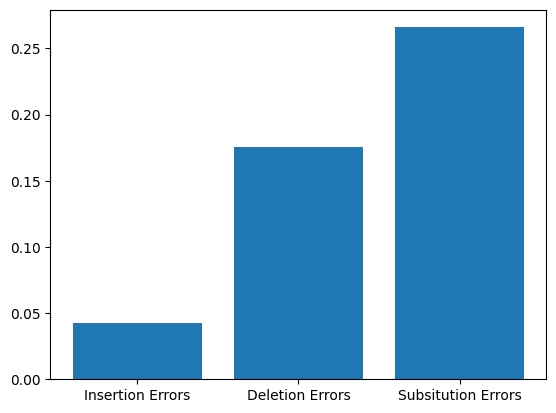

In [91]:
columns = ['Insertion Errors', 'Deletion Errors', 'Subsitution Errors']
rates = [np.mean(insertion_rates), np.mean(deletion_rates), np.mean(subsitution_rates)]

plt.bar(columns, rates)

## Training curve

In [67]:
log_path = r"C:\Users\Parv\OneDrive\Documents\models\log.txt"
log_text = ""

In [23]:
with open(log_path, "r") as f:
    log_text = f.readlines()

In [43]:

epochs = []
batch = []
loss = []
motifs_identified = []
edit_distance = []
for i in log_text:
    if i == '\n':
        continue
    split_line = i.split()
    if len(split_line) > 5:
        epochs.append(split_line[1])
        batch.append(split_line[3])
        loss.append(split_line[5])
        motifs_identified.append(split_line[-1])
        edit_distance.append(split_line[-3])

In [53]:
edit_distance = [float(i.replace('Motifs', '')) for i in edit_distance if not (i=='Edit' or i =='')]